## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.subpatch_extraction import *
from model_scripts.clustering import *
from evaluation_scripts.result_visualiser import *
from evaluation_scripts.label_helper import *
from Pipeline.temporal_preprocessing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Experiment 1: Data Cubes = B10 (Sentinel-2 Bands)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

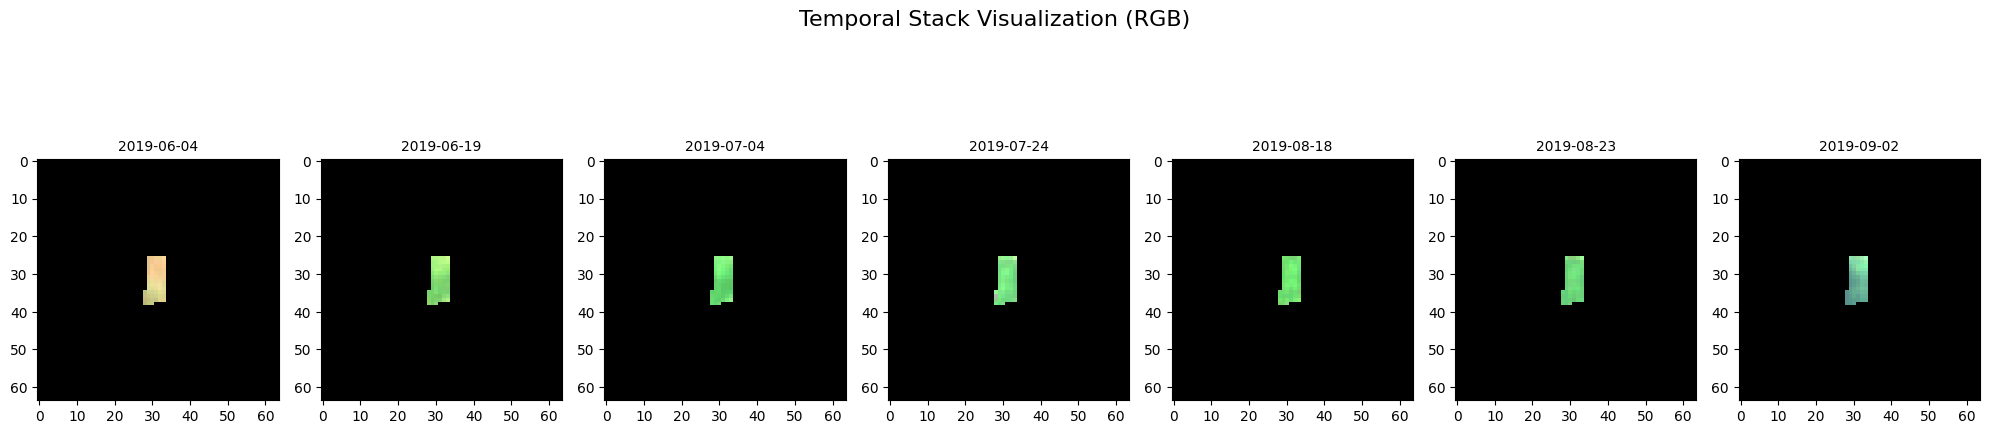

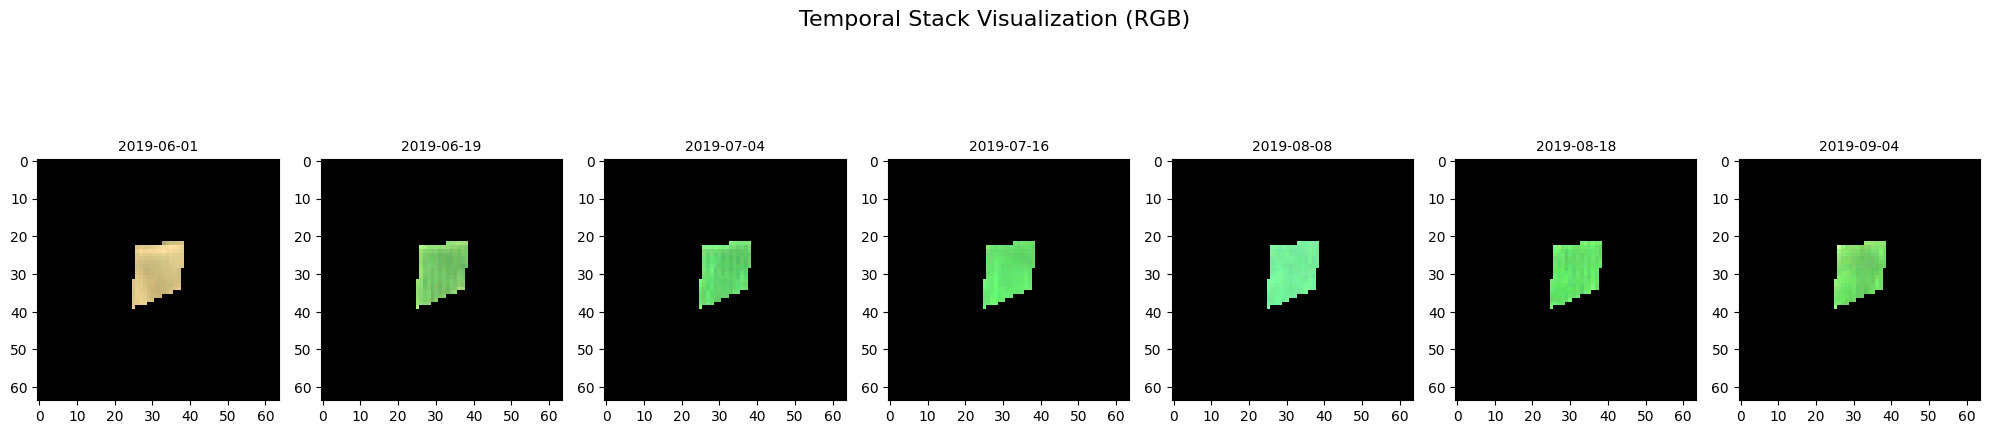

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

In [11]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

### Create Sub-Patches

In [5]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Visualise how sub-patches are created

In [6]:
# visualize_subpatches(patch_tensor_eval, field_numbers_eval, eval_subpatch_coords, 1, patch_size=config.subpatch_size)

### Modeling: k-means

Clustering the sub-patches 

In [7]:
kmeans_b10 = train_kmeans_patches(train_subpatches, n_clusters=2, random_state=1)

train_subpatch_predictions = kmeans_b10.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmeans_b10.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [8]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels(train_subpatch_coords, train_subpatch_predictions, threshold)
test_field_labels = assign_field_labels(eval_subpatch_coords, test_subpatch_predictions, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [9]:
accuracy, report, cm = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

Test Accuracy: 0.639344262295082
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        26
           1       0.62      0.94      0.75        35

    accuracy                           0.64        61
   macro avg       0.69      0.59      0.55        61
weighted avg       0.68      0.64      0.58        61



Saving the Model

In [10]:
with open(config.kmeans_b10_path, 'wb') as file:
    pickle.dump(kmeans_b10, file)

## Experiment 2: Data Cubes = BVI (Bands with Vegetation Indices)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 6, 64, 64)

In [14]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'multipleindicesbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'multipleindicesbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 7, 64, 64]), torch.Size([48, 7, 7, 64, 64]))

### Create Sub-Patches

In [16]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 7, 5, 5]), torch.Size([867, 7, 7, 5, 5]))

Visualise how sub-patches are created

In [15]:
# visualize_subpatches(patch_tensor_eval, field_numbers_eval, eval_subpatch_coords, 0, patch_size=4)

### Modeling: k-means

Clustering the sub-patches 

In [20]:
kmeans_bvi = train_kmeans_patches(train_subpatches, n_clusters=2, random_state=2)

train_subpatch_predictions = kmeans_bvi.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmeans_bvi.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [21]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels(train_subpatch_coords, train_subpatch_predictions, threshold)
test_field_labels = assign_field_labels(eval_subpatch_coords, test_subpatch_predictions, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [22]:
accuracy, report, cm = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

Test Accuracy: 0.5901639344262295
              precision    recall  f1-score   support

           0       0.57      0.15      0.24        26
           1       0.59      0.91      0.72        35

    accuracy                           0.59        61
   macro avg       0.58      0.53      0.48        61
weighted avg       0.58      0.59      0.52        61



In [24]:
with open(config.kmeans_bvi_path, 'wb') as file:
    pickle.dump(kmeans_bvi, file)

## Experiment 3: Data Cubes = MVI (Multiple Vegetation Indices)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 3, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'multipleindices')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'multipleindices')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 3, 5, 5]), torch.Size([867, 7, 3, 5, 5]))

Visualise how sub-patches are created

In [7]:
# visualize_subpatches(patch_tensor_eval, field_numbers_eval, eval_subpatch_coords, 1, patch_size=5)

### Modeling: k-means

Clustering the sub-patches 

In [8]:
kmeans_mvi = train_kmeans_patches(train_subpatches, n_clusters=2, random_state=3)

train_subpatch_predictions = kmeans_mvi.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmeans_mvi.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [9]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels(train_subpatch_coords, train_subpatch_predictions, threshold)
test_field_labels = assign_field_labels(eval_subpatch_coords, test_subpatch_predictions, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [10]:
accuracy, report, cm = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

Test Accuracy: 0.5737704918032787
              precision    recall  f1-score   support

           0       0.50      0.12      0.19        26
           1       0.58      0.91      0.71        35

    accuracy                           0.57        61
   macro avg       0.54      0.51      0.45        61
weighted avg       0.55      0.57      0.49        61



In [11]:
with open(config.kmeans_mvi_path, 'wb') as file:
    pickle.dump(kmeans_mvi, file)